In [1]:
import re
import csv
import glob
import json
import time
import math
import os, sys
import numpy as np

%load_ext autoreload
%autoreload 2

import brewer2mpl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

params = {
   'axes.labelsize': 14,
   'font.size': 14,
   'font.family': 'Roboto',
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'axes.labelsize': 25,
   'axes.titlesize': 25,
   'text.usetex': False,
   'figure.figsize': [10, 6]
}
matplotlib.rcParams.update(params)

import seaborn as sns
import pandas as pd

## Binding energy target histogram

In [6]:
id_prop_csv = "data/2019_09_23/energy-regression/id_prop.csv"

labels = []

with open(id_prop_csv, "r") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        labels.append(line)

print(labels[:10])
print(len(labels))

[['5d38288f38bc9b2cc323c520', '-0.2745123599999939'], ['5d38288f38bc9b2cc3241ba1', '-0.399856969999993'], ['5d38289038bc9b2cc3245358', '-0.5711927099999823'], ['5d38289038bc9b2cc324a85e', '-1.5067253500000017'], ['5d38288f38bc9b2cc323f643', '0.006865130000003106'], ['5d38288f38bc9b2cc3241ece', '-0.3128394199999942'], ['5d38288f38bc9b2cc323670b', '0.077667099999994'], ['5d38288f38bc9b2cc323d9da', '-1.813244310000007'], ['5d38289038bc9b2cc324587f', '-0.10474302999999985'], ['5d38288f38bc9b2cc323fbd6', '0.16763247999998931']]
16833


In [25]:
energies = [float(x[1]) for x in labels]
print(len(energies))
print(np.mean(energies))

16833
-0.6784944109938813


In [23]:
np.mean(np.absolute(np.array(energies[-1000:]) - np.mean(energies[-1000:])))

0.5257947870720602

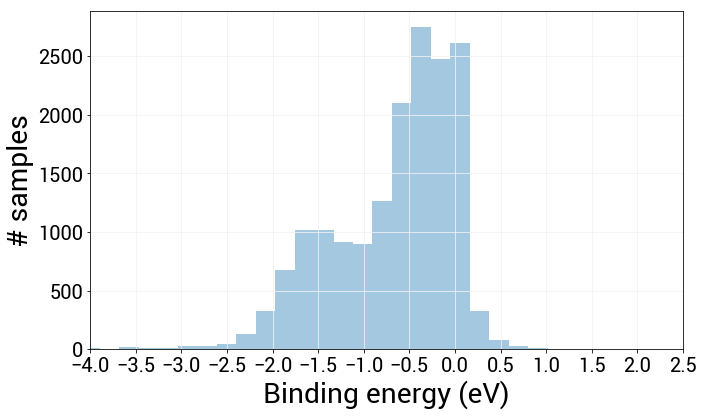

In [52]:
sns.distplot(energies, kde=False)

plt.grid(color='0.95')

plt.xlim(-4, 2)
plt.xticks(np.arange(-4, 2+1, 0.5))

plt.ylabel('# samples', fontsize=28)
plt.xlabel('Binding energy (eV)', fontsize=28)

plt.tight_layout()
plt.savefig("figures/2019_09_26_dist.png", dpi=150)

In [21]:
sub_energies = [-0.3439774300000007,-1.9737690200000113,-0.11386746000000691,-0.060876200000000935,-1.0751637800000164,-0.18612654999999556,-0.6577484900000083,-0.4924235300000017,-0.10215401999999862,-0.7531835400000002,-1.5522841800000062,-0.0557145400000163,-0.47727744999999366,-0.7171776999999988,-1.2391770899999894,-0.05602932000001282,-0.2893274800000025,-1.0093796099999874,-0.2627113999999917,-0.04272685999999304,-0.022592870000002208,-0.17530101999999737,-0.15929781999999726,-0.5493107199999994,0.01022049000000358,-0.38177319999998893,-0.08271938000000567,-1.0445069600000263,-0.5751687899999975,-0.3312355600000014,-1.348761129999998,-0.7117932800000002]
print(np.mean(sub_energies))
print(np.mean(np.absolute(np.array(sub_energies) - np.median(sub_energies))))

-0.5260417465625014
0.38388940781250014


## Loss curves

In [115]:
root_dir = "data/2019_10_05/data-vs-mae"
log_files = [("run-2019-10-07-17-20-39-ulissigroup_co_1k-tag-Validation_MAE.json", "1k"),
             ("run-2019-10-07-17-21-13-ulissigroup_co_2k-tag-Validation_MAE.json", "2k"),
             ("run-2019-10-07-17-21-45-ulissigroup_co_4k-tag-Validation_MAE.json", "4k"),
             ("run-2019-10-07-17-22-07-ulissigroup_co_8k-tag-Validation_MAE.json", "8k"),
             ("run-2019-10-07-22-22-55-ulissigroup_co_14k-tag-Validation_MAE.json", "14k")]

df = pd.DataFrame(columns=['method', 'iter', 'mae'])

for i in log_files:
    log = json.load(open(os.path.join(root_dir, i[0]), "r"))
    for x in log:
        df = df.append({'method': i[1],
                        'iter': x[1],
                        'mae': x[2]}, ignore_index=True)

    # !!! exponentially-weighted smoothing.
    df.loc[df.method == i[1], "mae_smooth"] = df.loc[df.method == i[1], "mae"].ewm(alpha=0.35).mean()

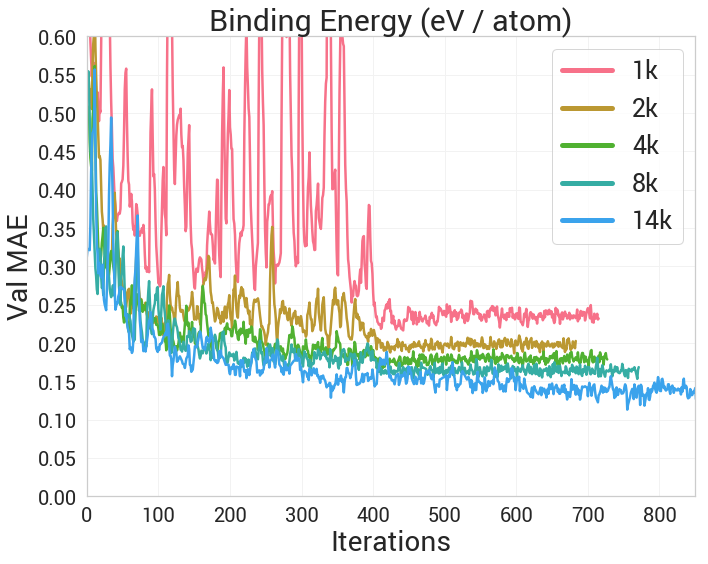

In [118]:
sns.set(style="whitegrid", font="Roboto")
sns.set_palette('husl')

fig, ax = plt.subplots(figsize=(10, 8))
g = sns.lineplot(x='iter',
                 y='mae_smooth',
                 hue='method',
                 data=df,
                 lw=2.5,
                 ax=ax,
                 hue_order=['1k', '2k', '4k', '8k', '14k'])

handles, labels = ax.get_legend_handles_labels()
for handle in handles:
    handle.set_linewidth(5)
ax.legend(handles=handles[1:], labels=labels[1:], fontsize=25)

plt.xlim(0, 850)
plt.ylim(0, 0.6)

plt.xticks(fontsize=20)
plt.yticks(np.arange(0, 0.65, 0.05), fontsize=20)

plt.xlabel("Iterations", fontsize=28)
plt.ylabel("Val MAE", fontsize=28)
plt.title("Binding Energy (eV / atom)", fontsize=30)

plt.grid(color='0.95')
plt.tight_layout()
plt.savefig('figures/2019_10_05_mae_vs_data.png', dpi=150)